# Neural networks in Python

This is a very basic exploration of neural networks. It should be emphasised that I will here use very shallow networks - this therefore does not explore *deep learning* networks. Part of the reason for this is that it requires installation of a more complex set of Python routines and the preferred way to do this is to install this in a separate virtual environment. What I will show here, in contrast, works straight out of the box of `sklearn`. 

In [1]:
import numpy as np
from astropy.io import fits
from astropy.table import Table
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

%matplotlib inline

In [10]:

def read_morphology_catalogue():
    """
    Get the original Nair & Abraham morphology catalogue 
    """
 
    # ADJUST THIS LOCATION IF NECESSARY!!
    fname = '../../Datasets/Nair-Abraham-2010-edited-for-class-all.fits'
    hdul = fits.open(fname)
    t = hdul[1].data
    hdul.close()
    return t


In [11]:
t = read_morphology_catalogue()

In [12]:
t.columns

ColDefs(
    name = 'SDSS'; format = '20A'
    name = 'Z'; format = 'E'
    name = 'SPID'; format = '14A'
    name = 'RP50'; format = 'E'
    name = 'RP90'; format = 'E'
    name = 'SFRT'; format = 'E'
    name = 'SFRM'; format = 'E'
    name = 'AGE'; format = 'E'
    name = 'MUG'; format = 'E'
    name = 'MUM'; format = 'E'
    name = 'B_A'; format = 'E'
    name = 'NG'; format = 'E'
    name = 'NR'; format = 'E'
    name = 'SIGMA'; format = 'E'
    name = 'T_TYPE'; format = 'J'
    name = 'PLATEID'; format = 'J'
    name = 'MJD'; format = 'J'
    name = 'FIBERID'; format = 'I'
    name = 'RA'; format = 'E'
    name = 'DEC'; format = 'E'
    name = 'V_DISP'; format = 'E'
    name = 'ABS_G'; format = 'E'
    name = 'UG_REST'; format = 'E'
    name = 'GR_REST'; format = 'E'
    name = 'RI_REST'; format = 'E'
    name = 'IZ_REST'; format = 'E'
    name = 'CLASS'; format = 'I'
    name = 'LGM'; format = 'E'
    name = 'GR'; format = 'E'
    name = 'RI'; format = 'E'
    name = 'IZ'; forma

# Calculating the mass of a galaxy

Normally to calculate the mass of a galaxy, you need to fit models to the colours of the object to determine the $M/L$ ratio. From this ratio and a magnitude you can then get an estimate of the mass. This all assumes that you know the cosmology. Here we will try to use a neural network to learn how to calculate masses without knowing anything about the cosmology or about models of stars.

So for input we use the colours: $u-g$, $g-r$, $r-i$, $i-z$, as well as the redshift, $z$, and the r-band magnitude, $r$.

In [13]:
ok, = np.where(np.isfinite(t['ug']) & np.isfinite(t['gr']) & np.isfinite(t['ri']) & np.isfinite(t['iz']) &
               np.isfinite(t['RMAG']) & np.isfinite(t['LGM']) & (t['LGM'] > 8) & (t['LGM']< 12))

/Users/jarle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/Users/jarle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


In [14]:
data = np.vstack([t['ug'][ok], t['gr'][ok], t['ri'][ok], t['iz'][ok], t['Z'][ok], t['RMAG'][ok]]).T
target = t['LGM'][ok]

In [15]:
# The optimized might matter here.
nn = MLPRegressor(activation='relu', solver='lbfgs', alpha=1e-4)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data, target)

In [18]:
lgm_est = nn.fit(X_train, y_train).predict(X_test)

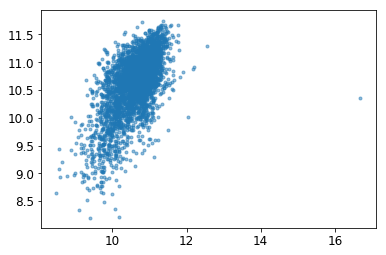

In [19]:
plt.scatter(lgm_est, y_test, marker='.', alpha=0.5)

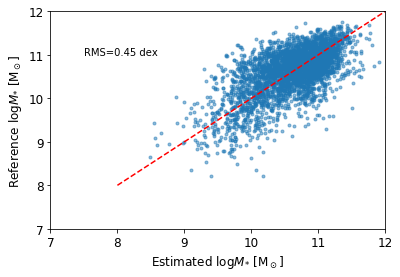

In [20]:
plt.scatter(lgm_est, y_test, marker='.', alpha=0.5)
plt.xlim(7, 12)
plt.ylim(7, 12)
xp = np.linspace(8, 12, 10)
plt.plot(xp, xp, ls='dashed', color='red')
plt.xlabel(r'Estimated $\log M_{*}$ [M$_\odot$]')
plt.ylabel(r'Reference $\log M_{*}$ [M$_\odot$]')

diff = lgm_est-y_test
keep_for_sigma, = np.where(np.abs(diff) < 2)
sig = np.std(diff[keep_for_sigma])
plt.text(7.5, 11, r"RMS={0:.2f} dex".format(sig))

So, this is fairly nice. While there are a couple of bad outliers, the scatter here is fairly good. It might be possible to improve on this by modifying the regularisation, transforming the input or by adding additional variables. These are all worth trying, but even out of the box this performance is pretty good.

To improve I therefore ran a 10-fold cross-validation (not included here as the code takes a long time to run) to determine alpha using the input variables above. This gave a best alpha of of 0.00483. Running with this alpha instead, reduces the scatter to 0.32 dex, which is very respectable, but there might be more systematic offsets.  Try it out!

The next step is exploring other input parameters and thereafter to change the sampling, so that you have approximately equal number of examples per input mass. Those are exercises for the reader :)

What is really neat here is that we can estimate the mass of galaxies without knowing anything about cosmology - the neural network figures that out for you. Unfortunately it is hard to know what goes on inside the black box that is the neural networks.